# Analysis of Gym Members Exercise Dataset

## I. Problem Statement
Goal: To identify which factors are highly impact the number of calories burned during workouts.

### Objectives
To answer the following questions:
* What factors played a role in determining the amount of calories burned while exercising? 
* How does the length of a workout affect the number of calories burned during the session? 
* How does a person's experience level influence the amount of calories they burn? 

## II. Import Dataset

* Lets begin by importing in the libraries and loading up the dataset. 
* This dataset offers a summary of the workout routines of gym members along with their characteristics and fitness activities. It comprises of 973 samples of gym related information with metrics, like heart rate, body weight, calories burned, etc.
* Dataset Reference:
    - Khorasani, V. (2023). Gym Members Exercise Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

In [182]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("gym_members_exercise_tracking.csv", index_col = 1)
len(data)

973

In [184]:
data.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
Gender,,,,,,,,,,,,,,
Male,56,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
Female,46,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
Female,32,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
Male,25,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
Male,38,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


## III. Prepare and explore dataset

### Check for missing values

In [186]:
data.isnull().sum()

Age                              0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64

### Convert categorical attributes

In [188]:
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns = categorical_columns, drop_first = True)

### Remove outliers

In [190]:
numerical_features = data.select_dtypes(include=['number']).columns

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for feature in numerical_features:
    data = remove_outliers_iqr(data, feature)


data.shape

(931, 16)

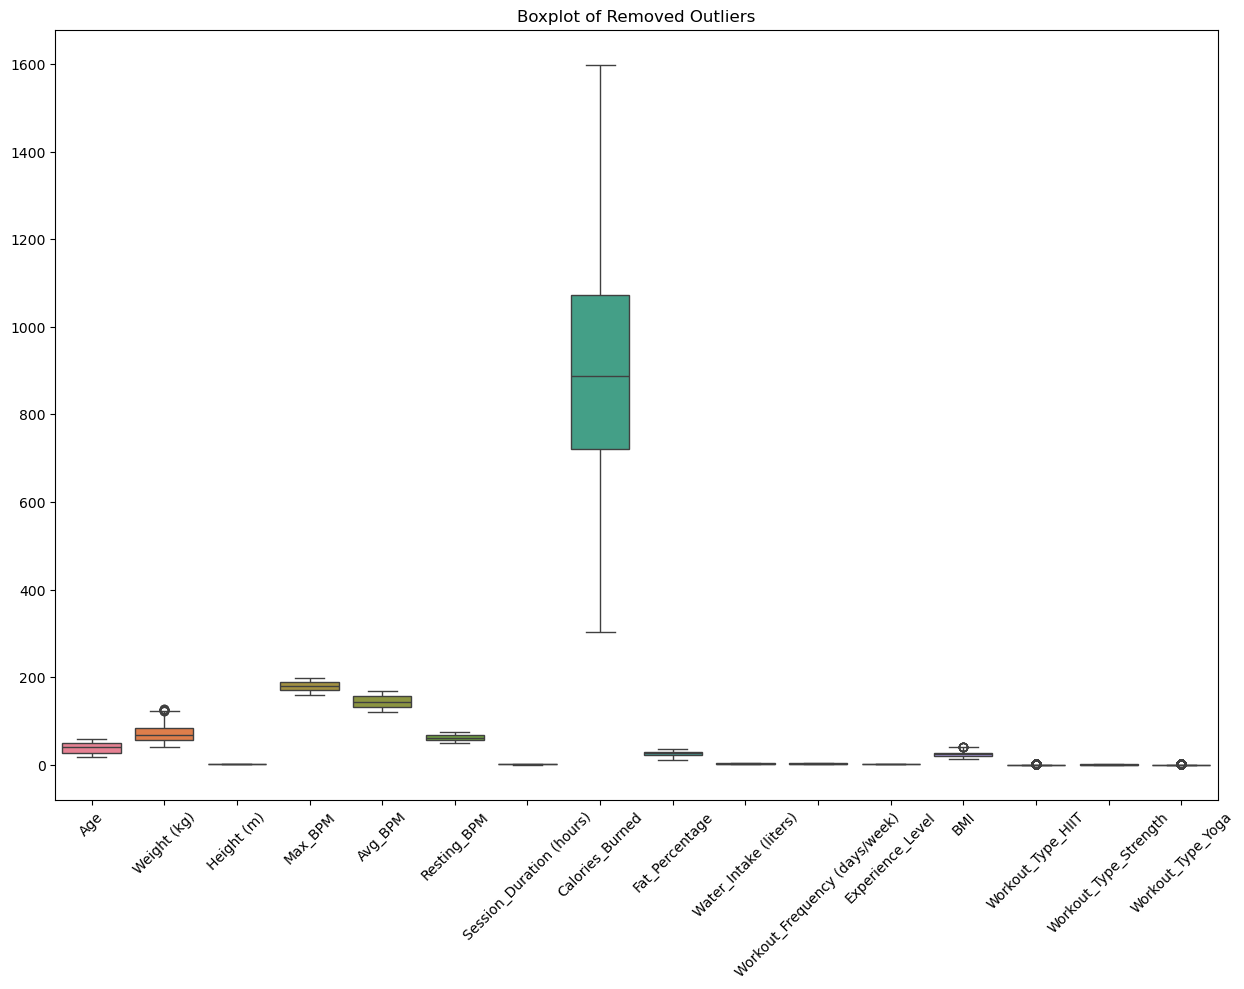

In [192]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.title('Boxplot of Removed Outliers')
plt.show()

### Correlation

In [194]:
correlation_matrix = data.corr()
print(correlation_matrix["Calories_Burned"].sort_values(ascending = False))

Calories_Burned                  1.000000
Session_Duration (hours)         0.908637
Experience_Level                 0.686462
Workout_Frequency (days/week)    0.568132
Water_Intake (liters)            0.346729
Avg_BPM                          0.314052
Weight (kg)                      0.108897
Height (m)                       0.092002
BMI                              0.067239
Workout_Type_HIIT                0.035388
Workout_Type_Yoga                0.011069
Resting_BPM                      0.000914
Max_BPM                         -0.003207
Workout_Type_Strength           -0.008613
Age                             -0.132964
Fat_Percentage                  -0.583512
Name: Calories_Burned, dtype: float64


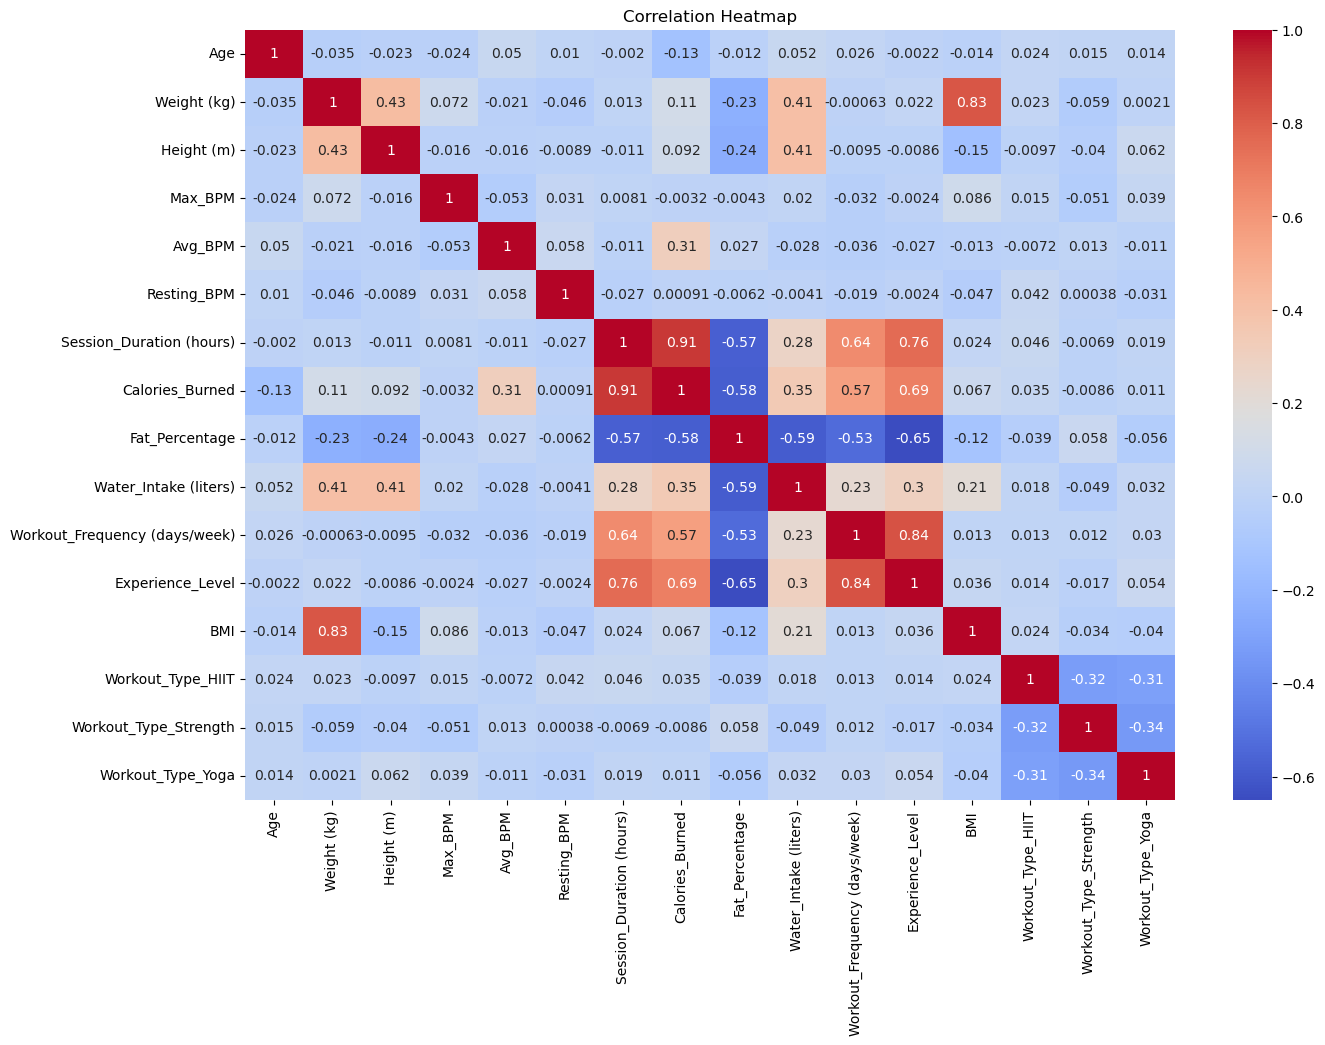

In [196]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Correlation Analysis

The correlation results showed that the duration of workout sessions has the highest positive correlation with the number of calories burned at 0.9086 – implying that longer workout sessions result in higher calories burned. Additionally, the experience level and frequency of exercise also had a moderate positive correlation with calories burned at 0.6864 and 0.5681, respectively suggesting that experienced individuals and those who work out regularly tend to burn more calories. On the other hand, there is a moderate negative correlation between body fat percentage and calories burned at -0.5835 suggesting that people with higher fat levels typically expend fewer calories in their workout sessions. These connections assist in pinpointing the factors influencing calorie burn and aid in determining which features to focus on for analysis and modeling purposes. 

### Scale numerical features

In [198]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

data.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
Gender,,,,,,,,,,,,,,,,
Male,1.419723,0.832920,-0.103497,0.008689,0.948726,-0.295231,1.282767,1.577783,-2.013600,1.479839,0.749842,1.617739,1.022724,False,False,True
Female,0.594447,0.145693,-1.504463,-0.078296,0.528990,0.520780,0.134331,-0.058795,1.407550,-0.852191,0.749842,0.264536,1.332428,True,False,False
Female,-0.560939,-0.203049,-0.492654,-1.122118,-1.499733,-1.111242,-0.425164,-0.842829,1.327241,-0.519044,0.749842,0.264536,0.078125,False,False,False
Male,-1.138632,-0.967204,-0.181328,0.878541,1.438418,-0.839238,-1.956413,-1.394698,0.588401,-0.852191,-0.346081,-1.088667,-1.005841,False,True,False
Male,-0.065774,-1.331332,0.519155,0.704570,1.018682,0.792784,-1.809178,-1.303355,0.652648,0.313824,-0.346081,-1.088667,-1.697515,False,True,False


## III. Analysis Technique 1: Hierarchical Cluster

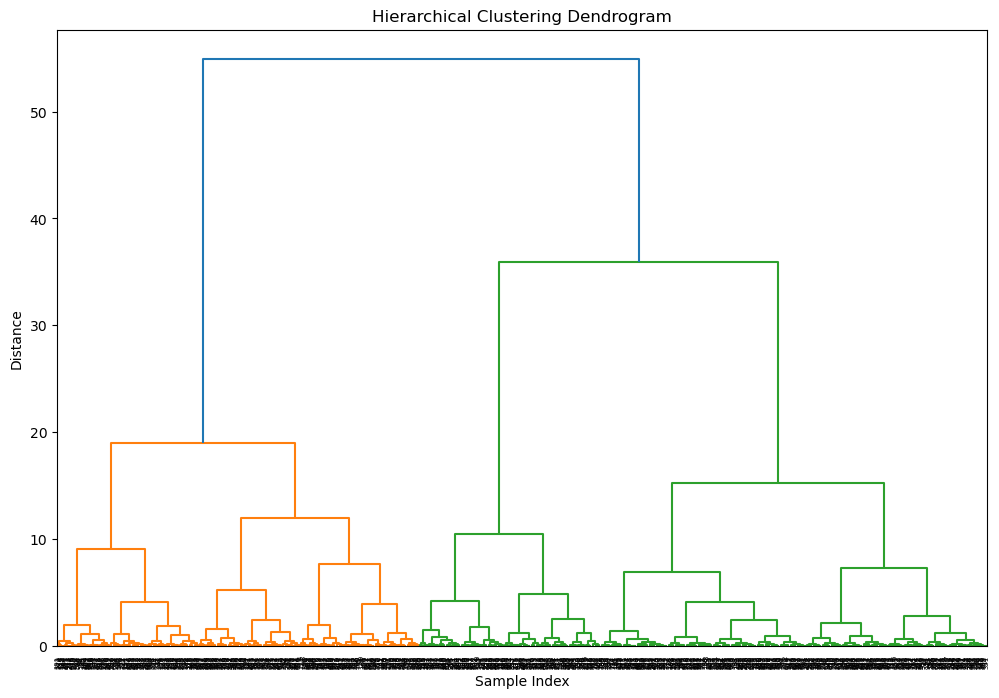

In [200]:
# Selected features
features = data[['Session_Duration (hours)', 'Experience_Level', 'Workout_Frequency (days/week)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

distance_matrix = pdist(X_scaled, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

### Form clusters based on dendrogram


Based on the dendrogram, three clusters were chosen because the significant height difference among the subjects suggests a natural split into three distinct groups.

In [202]:
hierarchical_clusters = cut_tree(linkage_matrix, n_clusters=3)
data['Cluster'] = hierarchical_clusters.flatten()

## IV. Evaluation of Hierarchical Clustering

### Silhouette score

In [204]:
silhouette_avg = silhouette_score(X_scaled, data['Cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_avg}')

Silhouette Score for Hierarchical Clustering: 0.5193959890311136


### Visualisation of clustering using PCA

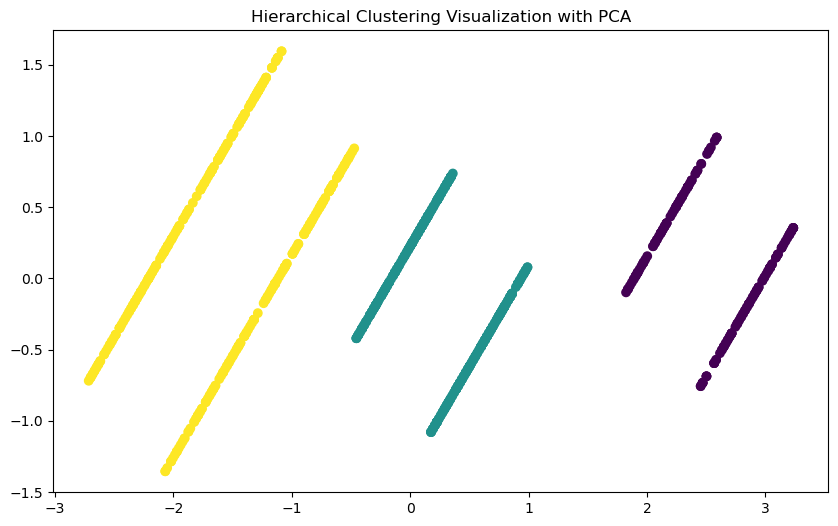

In [206]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Cluster'], cmap='viridis')
plt.title('Hierarchical Clustering Visualization with PCA')

plt.show()


### Analysis of Results

The hierarchical clustering analysis produced a silhouette score of 0.5194 which suggests a moderate level of cohesion and separation within clusters. While it can be seen from the PCA visualization that there are three clusters. The purple cluster is distinct and separate from the rest while suggesting that they share unique characteristics that set them apart from others. On the other hand, there is a very minimal overlap between the yellow and green cluster. The yellow cluster has scattered data points indicating a high variability in workout habits or session durations among its members. While green cluster shows a concentrated pattern suggesting a consistent workout behavior among its members.

## V. Analysis Technique 2: Linear and Polynomial Regression

### Linear Regression

In [208]:
# Create a function to reiterate linear regression calculations on each cluster
for cluster_id in data['Cluster'].unique():
    print(f"Cluster {cluster_id}")


    cluster_data = data[data['Cluster'] == cluster_id]

    # Split training and testing data
    X_cluster = cluster_data[['Session_Duration (hours)', 'Experience_Level', 'Workout_Frequency (days/week)']]
    y_cluster = cluster_data['Calories_Burned']
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    # Predict and calculate
    y_pred = lr_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = np.sum(np.abs(y_test - y_pred)) / len(y_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Square Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared: {r2}")
    print()

Cluster 0
Mean Square Error (MSE): 0.3433315105352338
Mean Absolute Error (MAE): 0.49962264335944423
R-squared: 0.03305647660394784

Cluster 1
Mean Square Error (MSE): 0.16783993982292786
Mean Absolute Error (MAE): 0.3294396539518668
R-squared: 0.42623936484784686

Cluster 2
Mean Square Error (MSE): 0.1326178375019246
Mean Absolute Error (MAE): 0.29228337757553013
R-squared: 0.8160696674720896



### Polynomial Regression

In [210]:
for cluster_id in data['Cluster'].unique():
    print(f"Cluster {cluster_id}")
    cluster_data = data[data['Cluster'] == cluster_id]

    # Split training and testing data
    X_cluster = cluster_data[['Session_Duration (hours)', 'Experience_Level', 'Workout_Frequency (days/week)']]
    y_cluster = cluster_data['Calories_Burned']
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply polynomial regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)


    # Predict and calculate
    y_pred_poly = poly_model.predict(X_test_poly)
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    mae_poly = np.sum(np.abs(y_test - y_pred_poly)) / len(y_test)
    r2_poly = r2_score(y_test, y_pred_poly)

    print(f"Mean Square Error (MSE): {mse_poly}")
    print(f"Mean Absolute Error (MAE): {mae_poly}")
    print(f"R-squared: {r2_poly}")
    print()

Cluster 0
Mean Square Error (MSE): 0.345923397182254
Mean Absolute Error (MAE): 0.5031884546180386
R-squared: 0.02575680287809079

Cluster 1
Mean Square Error (MSE): 0.1700262136441031
Mean Absolute Error (MAE): 0.3314227406967127
R-squared: 0.4187655903840487

Cluster 2
Mean Square Error (MSE): 0.13525778758030124
Mean Absolute Error (MAE): 0.2905662889213772
R-squared: 0.812408267882718



## VI. Analysis of Linear and Polynomial Regression Results

The results from the two regression models performed in all three clusters showed differences in their performance levels. In particular, Cluster 2 consistently performed the best with a its high R-squared values and low Mean Squared Error (MSE) and Mean Absolute Error (MAE). This suggests that the model effectively captured majority of the variance in calories burned resulting in accurate predictions. Cluster 1 performed moderately well with reasonable predictions; however there is still room for improvement by incorporating additional features or exploring interactions, between variables. On the other hand Cluster 0 performed the weakest as indicated by its significantly low R squared values and higher errors. This implies that the models had difficulty capturing the underlying patterns of calorie expenditure within its group of individuals. The linear regression model aimed to capture linear relationships in the three clusters wherein Clusters 0 and 1 didn't perform as well as Cluster 2 based on their MSE, MAE, and R-squared valued. On the other hand, the polynomial regression model aimed to capture more complex, non-linear relationships and showed little to no improvements in the performance of Clusters 0 and 1, highlighting the need for an alternative modeling approach or the incorporation of additional features for these groups.

## VII. Conclusion

Overall, the exercise data of gym members in detail revealed few key discoveries about the factors that affects the calories burned during the member's workout sessions. Through our analysis of correlations between variables it was evident that workout duration had the most correlation to calories burned with other factors like experience level and workout frequency as moderately correlated. Furthermore, the clustering analysis shed light on groupings, within the data set showing patterns of separated clusters according to their silhouette score and PCA visualisation. The analysis of regression, on these groups displayed levels of effectiveness among them all; Cluster 2 showed the accuracy in prediction and a clear connection between selected features and calories burned; Cluster 1 had a moderate level of accuracy; however Cluster 0 performed poorly. Indicating that the variables considered in the analysis were not comprehensive enough to explain calorie burn for individuals, within this Cluster 0. The results emphasize how challenging it is to predict calories burned and suggest the importance of incorporating detailed characteristics or sophisticated models to capture the complex and distinct patterns that may not be linear or non-linear, within each group successfully. 

## VIII. Recommendation

To enhance the prediction performance of these models, it is suggested to gather more information for Cluster 0 emphasizing on elements that could have an impact on calories burned. Enriching the data with a range of characteristics might enhance the models. Furthermore utilizing more complex machine learning methods such, as Decision Trees, Random Forests, etc could offer reliable models that capture complex relationships in the data. Finally, consistently refreshing the models with data and regularly assessing their effectiveness will be vital to adjusting to any changing patterns in the workout routines of gym members.